#Twitter Sentiment Analysis

Загружаем библиотеки

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from itertools import cycle, islice
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Загружаем датасет

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?id=1Vp8sdNhl65g1OGkW78Z6i4_D5UAwpTq8', names=['id', 	'brand', 	'emotion',	'tweet'])
df.head()

,id,brand,emotion,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# 1. Cleaning Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       74682 non-null  int64 
 1   brand    74682 non-null  object
 2   emotion  74682 non-null  object
 3   tweet    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.shape[0]

71656

# 2. Outlier Removal

In [ ]:
df['num_char'] = df['tweet'].apply(len)
df['num_words'] = df['tweet'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['tweet'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,id,brand,emotion,tweet,num_char,num_words,num_sentences
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,11,1
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,13,1
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,11,1
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,11,1
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,13,1


In [ ]:
df.describe()

,id,num_char,num_words,num_sentences
count,71656.000000,71656.000000,71656.000000,71656.000000
mean,6436.437242,110.538127,22.972535,1.954491
std,3742.291368,79.409848,17.163287,1.638269
min,1.000000,1.000000,0.000000,0.000000
25%,3199.000000,49.000000,10.000000,1.000000
50%,6432.500000,93.000000,19.000000,1.000000
75%,9604.000000,155.000000,32.000000,2.000000
max,13200.000000,957.000000,198.000000,33.000000


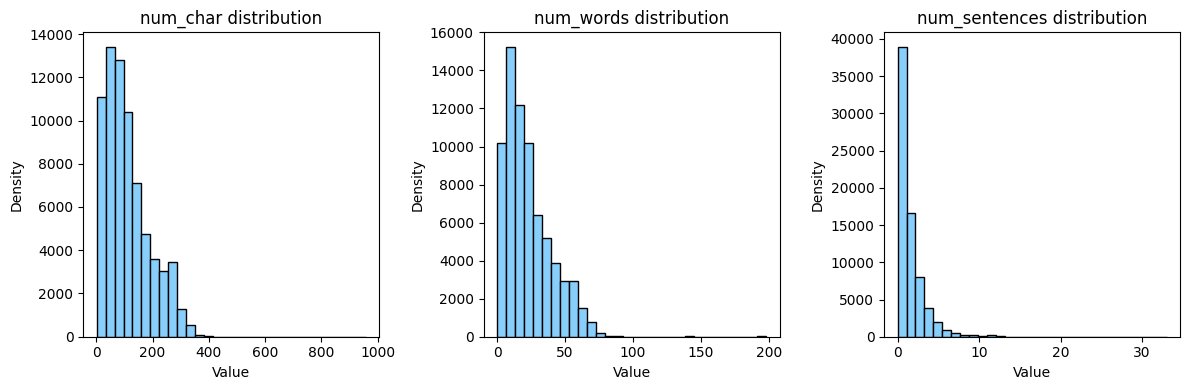

In [ ]:
plt.figure(figsize=(12, 4))

nums = ['num_char', 'num_words', 'num_sentences']

for i in range(len(nums)):
  plt.subplot(1, 3, i+1)
  df[nums[i]].plot(kind='hist', bins=30, title=f'{nums[i]} distribution', color='lightskyblue', edgecolor='black')
  plt.xlabel('Value')
  plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
def outlier_std(data, col, threshold=3):
  mean = data[col].mean()
  std = data[col].std() # сигма
  up = mean + threshold * std # верхняя грань
  low = mean - threshold * std # нижняя грань

  # все, что за пределами трех сигм - аномалия
  anomalies = pd.concat([data[col] > up, data[col] < low], axis=1).any(axis=1)
  return anomalies, up, low

In [ ]:
def get_column_outliers(data, col, func=outlier_std, threshold=3):
  # создание столбца - является ли значение выбросом
  outliers = pd.Series(data=[False]*len(data[col]), index=data[col].index, name='is_outlier')

  comparison_table = {}
  max_anomalies_percetage = 0.5 # должно быть 0.3 по правилу трех сигм

  # по каждому признаку
  for column in col:
    anomalies, up, low = func(data, column, threshold=threshold)
    anomalies_percentage = 100 * sum(anomalies)/len(anomalies)
    if anomalies_percentage < max_anomalies_percetage:
      comparison_table[column] = [up, low, sum(anomalies), 100 * sum(anomalies)/len(anomalies)]
      outliers.loc[anomalies[anomalies].index] = True

  comparison_table = pd.DataFrame(comparison_table).T
  comparison_table.columns=['up', 'low', 'anomalies_count', 'anomalies_percentage']
  return comparison_table, outliers

In [ ]:
comparison_table, std_outliers = get_column_outliers(df, ['num_char', 'num_words', 'num_sentences'])
comparison_table

,up,low,anomalies_count,anomalies_percentage
num_char,348.767669,-127.691416,147.0,0.205147
num_words,74.462395,-28.517325,248.0,0.346098


Значения количества выбросов для количества символов и слов лежит в пределах правила трех сигм, но количество предложений уже не удовлетворяет этому правилу, поэтому почистим выбросы только по первым двух параметрам.

In [ ]:
print(f"Total number of outliers: {sum(std_outliers)}\nPercentage of outliers {100 * sum(std_outliers)/len(std_outliers)}")

Total number of outliers: 336
Percentage of outliers 0.46890700011164455


In [ ]:
df['is_outlier'] = std_outliers
df = df.loc[df['is_outlier'] != True]
df = df.drop(['is_outlier'], axis=1)
df.head()

,id,brand,emotion,tweet,num_char,num_words,num_sentences
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,11,1
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,13,1
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,11,1
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,11,1
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,13,1


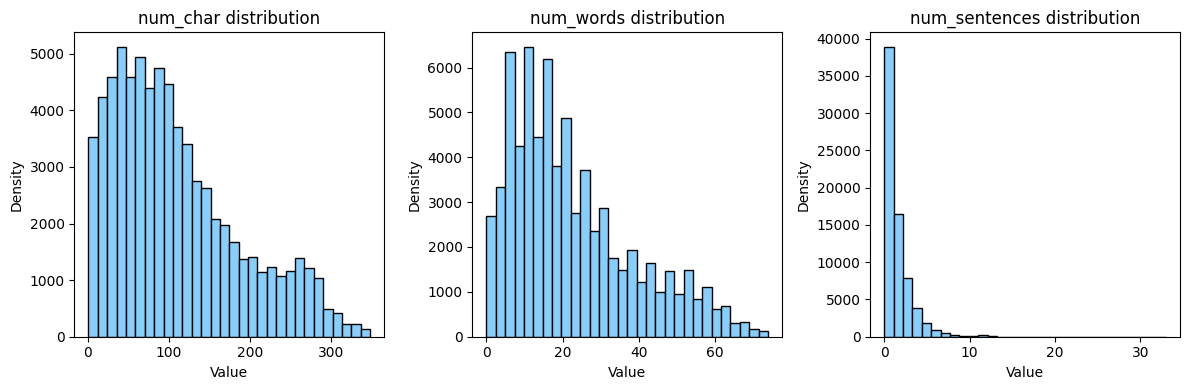

In [ ]:
plt.figure(figsize=(12, 4))

for i in range(len(nums)):
  plt.subplot(1, 3, i+1)
  df[nums[i]].plot(kind='hist', bins=30, title=f'{nums[i]} distribution', color='lightskyblue', edgecolor='black')
  plt.xlabel('Value')
  plt.ylabel('Density')

plt.tight_layout()
plt.show()

# 3. Text Preprocessing

In [ ]:
def transform_text(text):
    text = text.lower() # привели к маленьким буквам
    text = nltk.word_tokenize(text) # разбили на токены - слова
    lemmatizer = WordNetLemmatizer() # леммантайзер - приводит к начальной форме

    # удаление символов
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()

    # удаление стоп-слов
    for i in text:
        if i not in stopwords.words('english'):
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        y.append(lemmatizer.lemmatize(i))

    return " ".join(y)

In [ ]:
df['transformed_tweet'] = df['tweet'].apply(transform_text)
df.head()

,id,brand,emotion,tweet,num_char,num_words,num_sentences,transformed_tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,11,1,im getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,13,1,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,11,1,im getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,11,1,im coming borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,13,1,im getting borderland 2 murder


# 4. Data Distribution

Text(0.5, 1.0, 'Category Distribution')

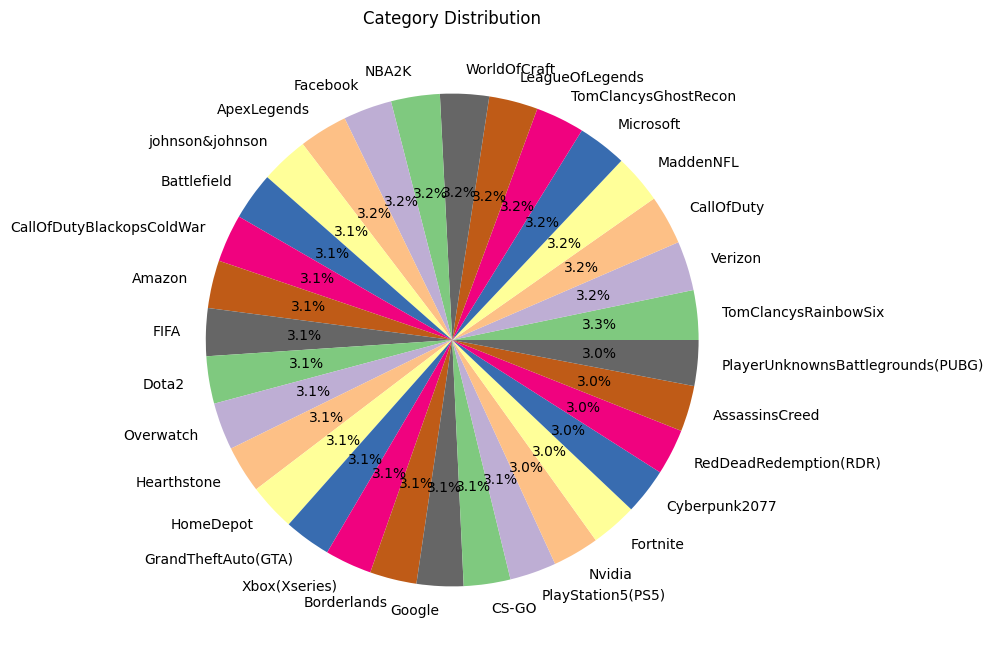

In [ ]:
value_counts= df['brand'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=plt.cm.Accent.colors)
plt.title("Category Distribution")

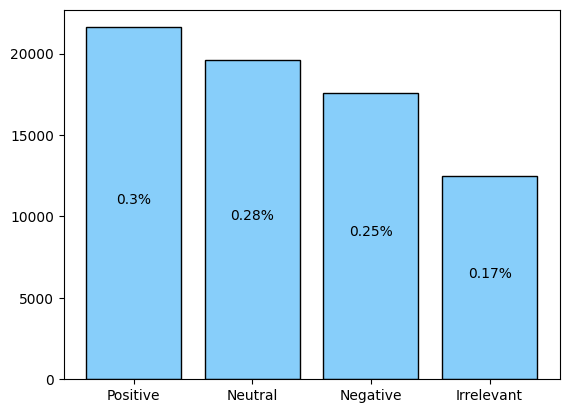

In [ ]:
data_plt = pd.DataFrame(df['emotion'].value_counts())
x = data_plt.index.to_list()
y = data_plt["count"].to_list()
fig, ax = plt.subplots()
pps = ax.bar(x, y, color='lightskyblue', edgecolor='black')
for p in pps:
   height = round(p.get_height() / sum(y), 2)
   ax.text(x=p.get_x() + p.get_width() / 2, y=p.get_height()/2,
      s="{}%".format(height),
      ha='center')
emotions = df['emotion'].unique()
plt.xticks(range(len(emotions)), emotions, rotation=0)
plt.show()

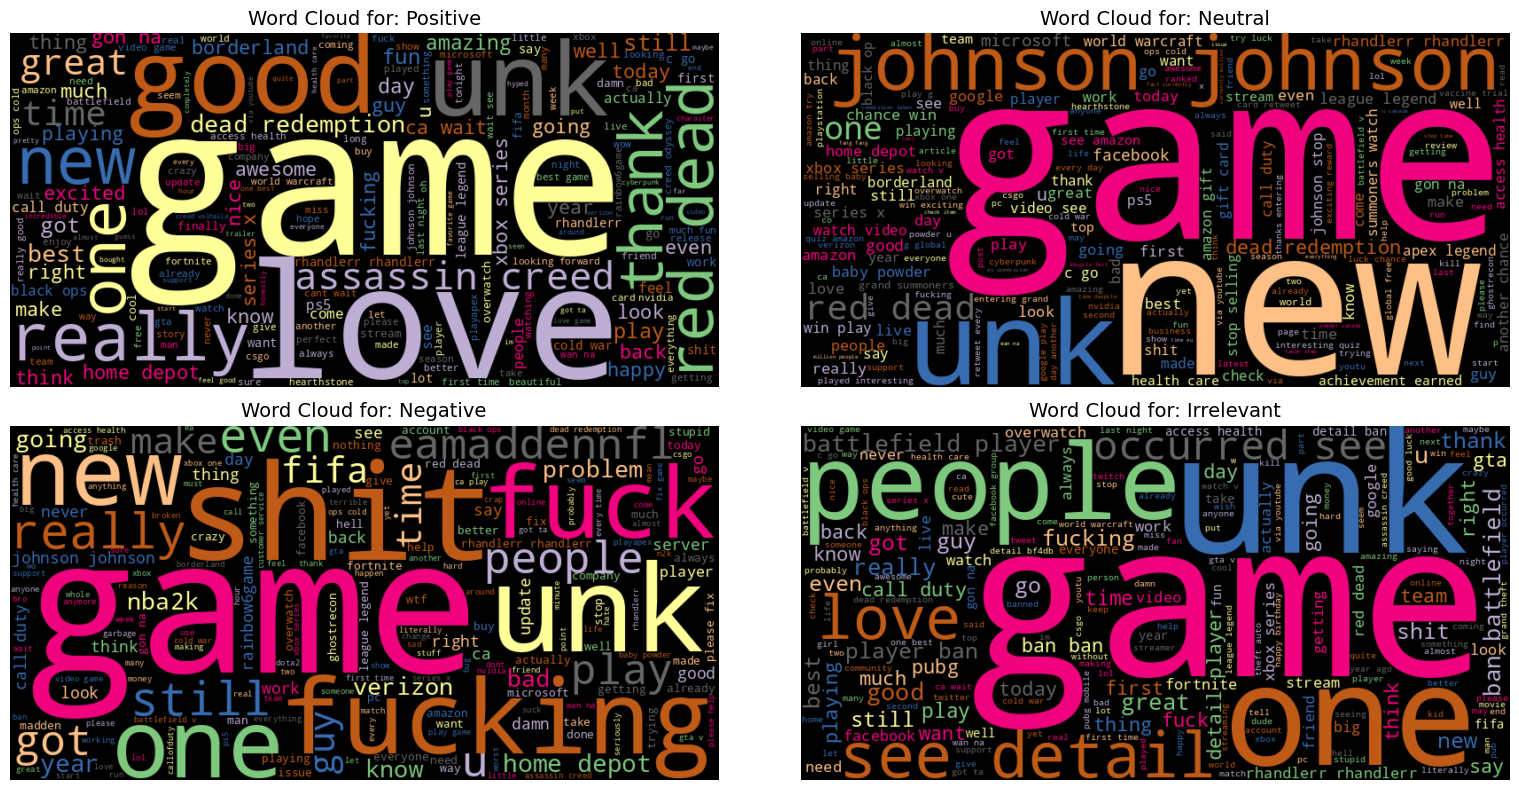

In [ ]:
wc = WordCloud(width=800, height=400, min_font_size=5, background_color='black',colormap="Accent")
plt.figure(figsize=(16, 8))

for i in range(len(emotions)):
  plt.subplot(2, 2, i+1)
  wcloud = wc.generate(df[df['emotion']==emotions[i]]['transformed_tweet'].str.cat(sep=" "))
  plt.imshow(wc, interpolation='bilinear')
  plt.title(f'Word Cloud for: {emotions[i]}', fontsize=14)
  plt.axis('off')

plt.tight_layout()
plt.show()

<Axes: xlabel='brand'>

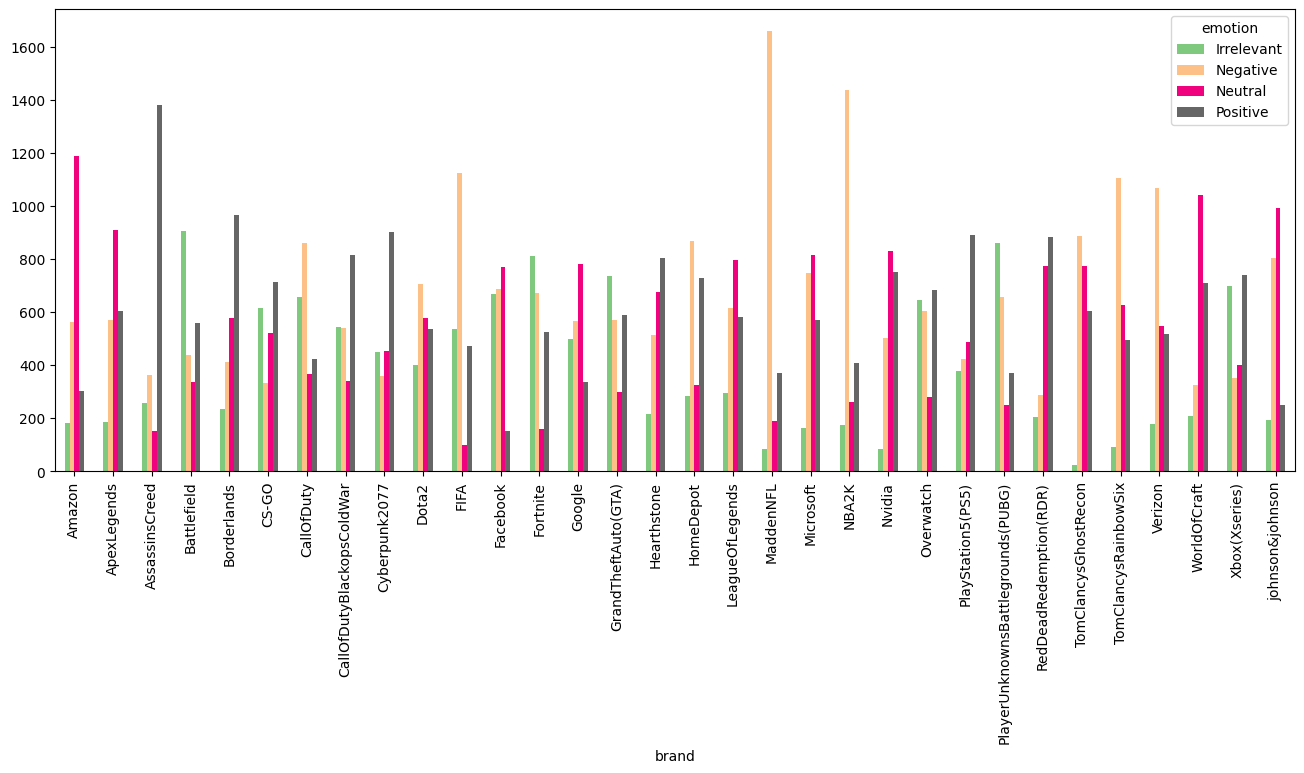

In [ ]:
crosstab_plot = pd.crosstab(df['brand'],df['emotion'])
crosstab_plot.plot(kind='bar', figsize=(16, 6), cmap="Accent")

# 5. Balancing Data

In [ ]:
balanced_data = pd.DataFrame()
min_size = df['emotion'].value_counts().min()  # downsampling

for em in emotions:
    class_subset = df[df['emotion'] == em]
    balanced_subset = resample(class_subset, replace=True, n_samples=min_size, random_state=42)
    balanced_data = pd.concat([balanced_data, balanced_subset])

print(balanced_data['emotion'].value_counts())
balanced_data.head()

emotion
Positive      12468
Neutral       12468
Negative      12468
Irrelevant    12468
Name: count, dtype: int64


,id,brand,emotion,tweet,num_char,num_words,num_sentences,transformed_tweet
57148,11403,TomClancysRainbowSix,Positive,I love our @Rainbow6Game so much.,33,8,1,love rainbow6game much
2027,2755,Borderlands,Positive,IM SO EXCITED FOR THIS and I am AFFORD NOT TO ...,94,20,1,im excited afford drop steam must love borderl...
18872,12434,WorldOfCraft,Positive,"ah, cozy.. sooooooo cozy..",26,7,1,ah cozy sooooooo cozy
41132,1459,Battlefield,Positive,4 любимые игры всем время?... Max Payne 2. Fif...,79,22,5,4 любимые игры всем время max payne fifa pubg ...
38873,5472,Hearthstone,Positive,@THETAtv. extremely excited to start streaming...,93,18,3,thetatv extremely excited start streaming hear...


# 6. TFIDF Vectorization

In [ ]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(balanced_data['transformed_tweet'])
y = balanced_data['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 7. Building Model

Кросс-валидация на модели случайного леса

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Средняя точность кросс-валидации: {np.mean(scores):.2f}")

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

Средняя точность кросс-валидации: 0.87
              precision    recall  f1-score   support

  Irrelevant       0.94      0.92      0.93      2511
    Negative       0.92      0.91      0.92      2498
     Neutral       0.86      0.91      0.88      2463
    Positive       0.91      0.89      0.90      2503

    accuracy                           0.91      9975
   macro avg       0.91      0.91      0.91      9975
weighted avg       0.91      0.91      0.91      9975



Мы получили достаточно высокую оценку модели, также важно, что модель для всех тональностей работает одинаково хорошо, поскольку мы применили балансировку данных.